In [2]:
def double_pendulum_equations(t, y, m1=1.0, m2=1.0, L1=1.0, L2=1.0, g=9.81):
    theta1, o1, theta2, o2 = y
    
    # Calculate differences
    delta = theta2 - theta1
    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) * np.cos(delta)
    den2 = (L2 / L1) * den1
    
    # Angular acceleration of first pendulum
    num1 = (-m2 * L1 * o1**2 * np.sin(delta) * np.cos(delta) +
            m2 * g * np.sin(theta2) * np.cos(delta) +
            m2 * L2 * o2**2 * np.sin(delta) -
            (m1 + m2) * g * np.sin(theta1))
    
    do1_dt = num1 / den1
    
    num2 = (-m2 * L2 * o2**2 * np.sin(delta) * np.cos(delta) +
            (m1 + m2) * (g * np.sin(theta1) * np.cos(delta) -
            L1 * o1**2 * np.sin(delta)) -
            (m1 + m2) * g * np.sin(theta2))
    
    do2_dt = num2 / den2
    
    return [o1, do1_dt, o2, do2_dt]

def simulate_double_pendulum(theta1_0, o1_0, theta2_0, o2_0, time_end=10, num_points=1000):
    
    y0 = [theta1_0, o1_0, theta2_0, o2_0]
    
    # Time array
    time = np.linspace(0, time_end, num_points)
    
    # Solve differential equation
    sol = solve_ivp(double_pendulum_equations, [0, time_end], y0, 
                   t_eval=time, method='RK45', rtol=1e-8)
    
    # Extract results
    theta1 = sol.y[0]
    o1 = sol.y[1]
    theta2 = sol.y[2]
    o2 = sol.y[3]
    
    return time, theta1, theta2, o1, o2

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ------------------------
# Parameters
# ------------------------

# time step duration (in time unit)
dt = 0.025
# training time (in time unit)
train_time  = 70.
# testing time (idem)
test_time   = 110.
# warmup time (idem): should always be > k * s
warm_time   = 30.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

total_time = train_time + test_time + warm_time


m1, m2 = 1.0, 1.0  # Masses of pendulum bobs (kg)
l1, l2 = 1.0, 1.0  # Lengths of pendulum arms (m)
g = 9.81         # Acceleration due to gravity (m/s^2)


n_timesteps = train_steps + test_steps + warm_steps



theta1_0 = np.pi/2    # 90 degrees
o1_0 = 0.0            # start from rest
theta2_0 = np.pi/2    # 90 degrees  
o2_0 = 0.0            # start from rest



# Simulate
time, theta1, theta2, o1, o2 = simulate_double_pendulum(
    theta1_0, o1_0, theta2_0, o2_0, time_end=total_time, num_points=n_timesteps
)

X = np.stack([theta1, theta2, o1, o2 ], axis=1)  
print(f"Shape of X: {X.shape}")


Shape of X: (8400, 4)


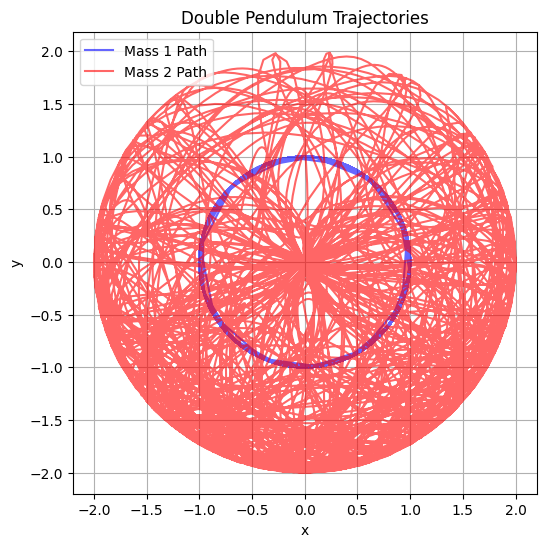

[1.57079633 1.56772996 1.55853082 1.54319846 1.52173071] [ 0.         -0.24527962 -0.49056635 -0.73589307 -0.98135198] [1.57079633 1.57079619 1.57079524 1.57078832 1.57074904] [ 0.00000000e+00 -5.13126469e-06 -9.53514211e-05 -6.65719149e-04
 -2.82848553e-03]


In [5]:


# ------------------------
# Convert to Cartesian: (x1, y1), (x2, y2)
def plot_data(th1, th2):

    # ------------------------
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)

    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)

    cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

    # ------------------------
    # Plot the trajectory
    # ------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
    plt.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
    plt.title("Double Pendulum Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(theta1, theta2)

print(theta1[:5], o1[:5], theta2[:5], o2[:5])




In [6]:
from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=6, strides=1) # 6 is good for order
readout = Ridge(4, ridge=2.5e-6, input_bias=False)

model = nvar >> readout

In [7]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Xi shape: (3999, 4), dXi shape: (3999, 4)


Running Model-0: 3999it [00:00, 5421.95it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.97565e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Fitting node Ridge-0...


Running NVAR-0: 100%|██████████| 2/2 [00:00<00:00, 2906.66it/s]


(4400, 4)
(4400, 4)


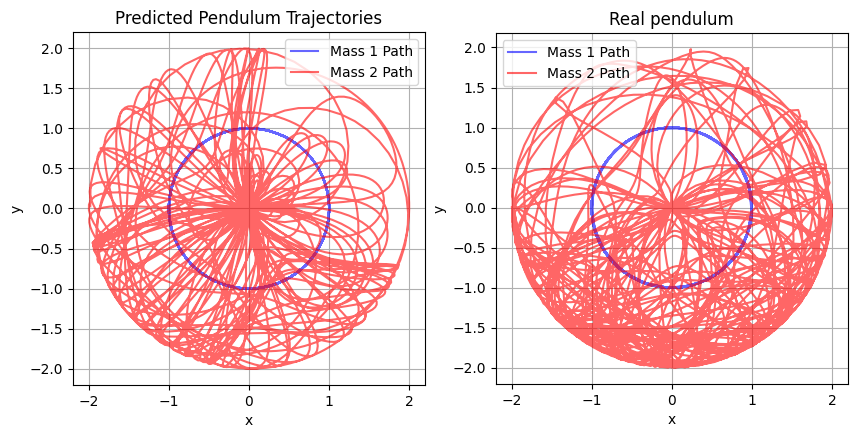

In [8]:
N = test_steps
Y = X[warm_steps+train_steps:]


fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(121)
ax.set_title("Generated pendulum")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(False)

th1 = res[:, 0]
th2 = res[:, 1]
x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

ax.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax.set_title("Predicted Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
ax.legend()
ax.grid(True)



ax2 = fig.add_subplot(122)
ax2.set_title("Real pendulum")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")


th1 = Y[:, 0]
th2 = Y[:, 1]

x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

ax2.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax2.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True)

print(res.shape)
print(Y.shape)



In [9]:
%matplotlib widget
import matplotlib.pyplot as plt

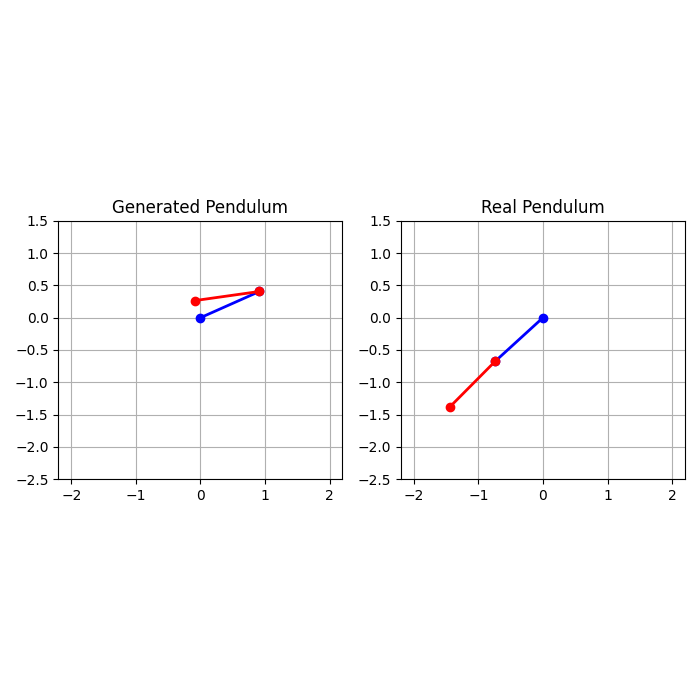

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter

# --- Pendulum lengths ---
l1, l2 = 1.0, 1.0

# --- Trajectory Data (already computed) ---
# X = full trajectory
# res = generated
# Y = ground truth
# test_steps, train_steps, warm_steps already defined

N = test_steps
Y = X[warm_steps + train_steps:]

# --- Helper: Convert angles to positions ---
def get_positions(data):
    th1, th2 = data[:, 0], data[:, 1]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)
    return x1, y1, x2, y2

# --- Get both trajectories in Cartesian coordinates ---
x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)

# --- Set up figure and axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")

# --- Initialize lines ---
gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

# --- Initialization function ---
def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2

# --- Update function for animation ---
def update(frame):
    # Generated
    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])

    # Real
    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

# --- Create animation ---
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

FFwriter = FFMpegWriter(fps=10)
ani.save('./pendulum_1.mp4', writer=FFwriter)

plt.tight_layout()
plt.show()


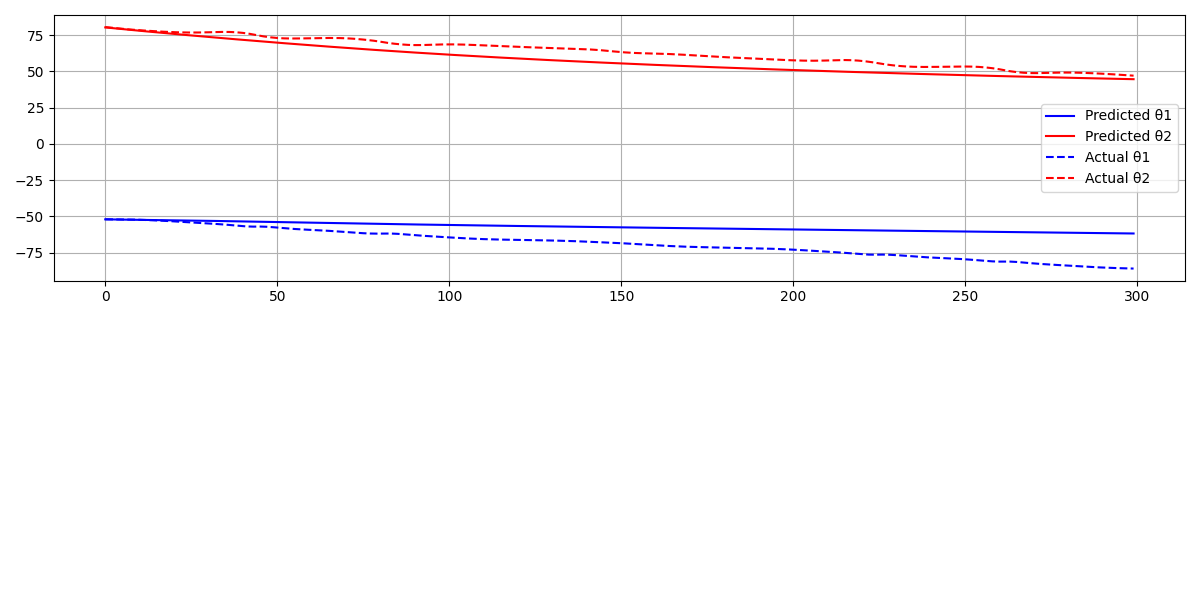

In [11]:
plt.figure(figsize=(12, 6))

N_display = 300
# Plot predicted (generated) angles
plt.subplot(2, 1, 1)
plt.plot(np.arange(N_display), res[:N_display, 0], label='Predicted θ1', color='blue')
plt.plot(np.arange(N_display), res[:N_display, 1], label='Predicted θ2', color='red')
plt.plot(np.arange(N_display), Y[:N_display, 0], label='Actual θ1', color='blue', linestyle='--')
plt.plot(np.arange(N_display), Y[:N_display, 1], label='Actual θ2', color='red', linestyle='--')

plt.legend()
plt.grid(True)

plt.grid(True)

plt.tight_layout()
plt.show()